In [1]:
import sys
sys.path.append('/nfs/stak/users/sumons/HP-OSU-Capstone-2023-2024-dev/')

In [2]:
import torch
import matplotlib.pyplot as plt
import os

from config.config import train_val_ratio, target
from dataloader.load_data import load_dataloader
from utils.save_load_model import save
from utils.metrics import binary_iou
from utils.convert import convertBinary

from config.args import get_arguments
from config.config import features,labels,duplex_labels,train_test_ratio,label_extension,threshold,random
from dataloader.load_data import *
from utils.load_json import load_results
from utils.save_load_model import load
from utils.convert import convertBinary


import logging
import os
import torch
import json
from torchvision.transforms.functional import to_pil_image
from torch.utils.data import random_split, DataLoader, Subset

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models.segmentation as segmentation

In [3]:
label_folder = '/nfs/hpc/share/sumons/working_folder/Data/Output'
input_folder = '/nfs/hpc/share/sumons/working_folder/Data/Input'

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [5]:
pdf,algorithm,intermediate = load_results(label_folder)

In [6]:
dataset = DuplexDetectDataset(input_folder,algorithm, pdf)

In [7]:
train_dataloader, val_dataloader = load_dataloader(dataset,8,train_val_ratio)

In [8]:
print(len(train_dataloader))
print(len(val_dataloader))

283
31


In [9]:
class CustomDeepLabV3(nn.Module):
    def __init__(self, num_classes=8):
        super(CustomDeepLabV3, self).__init__()
        # Initialize DeepLabV3 with a ResNet-50 backbone
        self.model = segmentation.deeplabv3_resnet50(pretrained=False, num_classes=num_classes)

        # Modify the first convolutional layer to accept 10-channel input instead of 3
        self.model.backbone.conv1 = nn.Conv2d(10, 64, kernel_size=7, stride=2, padding=3, bias=False)

    def forward(self, x):
        # DeepLabV3 forward pass
        output = self.model(x)['out']  # This will have shape [batch_size, num_classes, H, W]
        
        # Global Average Pooling (GAP)
        gap = torch.nn.functional.adaptive_avg_pool2d(output, (1, 1))  # Shape: [batch_size, num_classes, 1, 1]
        
        # Squeeze to remove spatial dimensions
        gap = torch.flatten(gap, 1)  # Shape: [batch_size, num_classes]
        
        # Sigmoid activation to get multi-label classification
        return torch.sigmoid(gap)

# Initialize the model
model = CustomDeepLabV3()
model = nn.DataParallel(model).to(device)
# checkpoint_path = '/nfs/hpc/share/sumons/working_folder/saved_models/duplex_detect.pth'
# model.load_state_dict(torch.load(checkpoint_path))


# Prepare an example input tensor
# input_tensor = torch.randn(4, 10, 300, 300).to(device)  # Adjusted for 8-channel input

# Forward pass
# output = model(input_tensor)

# Print the output shape to confirm it matches expectations
# print(output.shape)  # Should be torch.Size([4, 8])


/nfs/stak/users/sumons/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/nfs/stak/users/sumons/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [11]:
# print(torch.round(output))

In [12]:
criterion = nn.BCELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

In [13]:
def hamming_accuracy(y_pred, y_true):
    """Calculate the Hamming accuracy for predicted and true labels."""
    y_pred_binary = y_pred > 0.5
    correct = (y_pred_binary == y_true).float()
    return correct.mean()

In [14]:
num_epochs = 20
loss_deeplab = []
val_loss = []
train_accuracy = []
val_accuracy = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0
    running_val_loss = 0.0
    running_val_accuracy = 0.0

    for batch_data in train_dataloader:
        inputs, masks = batch_data[0].to(device), batch_data[1].to(device)
        inputs = inputs / 255.0
        optimizer.zero_grad()

        outputs = model(inputs.float())
        loss = criterion(outputs, masks)
        
        acc = hamming_accuracy(outputs, masks)  # Calculate accuracy
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_accuracy += acc.item()  # Accumulate accuracy

    epoch_loss = running_loss / len(train_dataloader)
    epoch_accuracy = running_accuracy / len(train_dataloader)  # Average accuracy
    loss_deeplab.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)  # Store training accuracy
    
    with torch.no_grad():
        model.eval()  # Set model to evaluation mode
        for batch_data in val_dataloader:
            inputs, masks = batch_data[0].to(device), batch_data[1].to(device)
            inputs = inputs / 255.0
            outputs = model(inputs.float())
            loss = criterion(outputs, masks)
            
            acc = hamming_accuracy(outputs, masks)  # Calculate accuracy for validation
            
            running_val_loss += loss.item()
            running_val_accuracy += acc.item()  # Accumulate validation accuracy
        
    epoch_val_loss = running_val_loss / len(val_dataloader)
    epoch_val_accuracy = running_val_accuracy / len(val_dataloader)  # Average validation accuracy
    val_loss.append(epoch_val_loss)
    val_accuracy.append(epoch_val_accuracy)  # Store validation accuracy

    # Save the model
    torch.save(model.state_dict(), '/nfs/hpc/share/sumons/working_folder/saved_models/duplex_detect.pth')
    
    # Print epoch, loss, and accuracy
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Acc: {epoch_accuracy:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_accuracy:.4f}")


Epoch [1/20], Loss: 0.3859, Acc: 0.8680, Val Loss: 0.1592, Val Acc: 0.9486
Epoch [2/20], Loss: 0.2536, Acc: 0.9172, Val Loss: 0.1020, Val Acc: 0.9667
Epoch [3/20], Loss: 0.1918, Acc: 0.9391, Val Loss: 0.1236, Val Acc: 0.9693
Epoch [4/20], Loss: 0.1510, Acc: 0.9506, Val Loss: 0.3170, Val Acc: 0.9617
Epoch [5/20], Loss: 0.1276, Acc: 0.9591, Val Loss: 0.1068, Val Acc: 0.9647
Epoch [6/20], Loss: 0.1127, Acc: 0.9641, Val Loss: 0.1068, Val Acc: 0.9758
Epoch [7/20], Loss: 0.1096, Acc: 0.9646, Val Loss: 0.3517, Val Acc: 0.9667
Epoch [8/20], Loss: 0.0988, Acc: 0.9689, Val Loss: 0.1122, Val Acc: 0.9698
Epoch [9/20], Loss: 0.0840, Acc: 0.9742, Val Loss: 0.0729, Val Acc: 0.9753
Epoch [10/20], Loss: 0.0772, Acc: 0.9767, Val Loss: 0.1428, Val Acc: 0.9723


KeyboardInterrupt: 

In [15]:
# prev_val_loss = val_loss
# prev_val_acc = val_accuracy

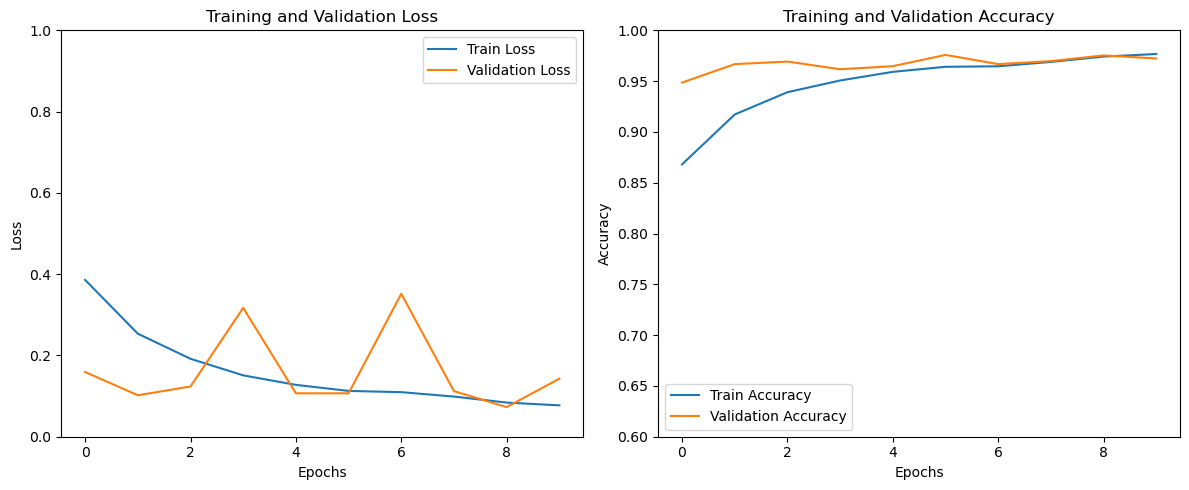

In [21]:
# Plotting Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(loss_deeplab, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 1)
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.6, 1)
plt.legend()

plt.tight_layout()
plt.show()

In [42]:
def eval_model():
    output_images = []
    masks_ = []
    model.eval()
    with torch.no_grad():
        for batch_data in val_dataloader:
            inputs, masks = batch_data[0].to(device), batch_data[1].to(device)
            inputs = inputs/255.0
            outputs = model(inputs.float())
            output_images.append(outputs.cpu())
            masks_.append(masks)
    return output_images, masks_

In [43]:
output_images, masks_ = eval_model()

In [53]:
import numpy as np

print(f' Original Labels: {masks_[0][0].cpu()}')
print(f' Non-binarized outputs: {output_images[0][0].cpu()}')



 Original Labels: tensor([1., 0., 0., 0., 1., 1., 0., 0.])
 Non-binarized outputs: tensor([0.9934, 0.0156, 0.0112, 0.0122, 0.9951, 0.9944, 0.0086, 0.0052])


In [ ]:
output_images